In [55]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import pandas as pd
import scanpy as sc

from pathlib import Path
import numpy as np
plt.rcParams["figure.figsize"] = (30,30)
import scipy.stats as stats
import pickle
import time
import timeit
SEED = 0
np.random.seed(SEED)
from sklearn.decomposition import PCA
from bicycle.utils.mask_utils import distance, above_threshold, add_noise, add_saltpepper, normalize_matrix, get_mask, get_mask_no_data, get_random_samples, get_sparsity, evaluate_model

In [56]:
data_path = Path("/data/toulouse/scMultiSim/run_04")
out_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data")
run_id = "scMultiSim_data/run_04"

In [57]:
atac_base = pd.read_csv(data_path/"atac_counts.csv", index_col=0).to_numpy(np.float32)
grn = pd.read_csv(data_path/"geff.csv", index_col=0).to_numpy(np.float32)
region_to_gene = pd.read_csv(data_path/"region_to_gene.csv", index_col=0).to_numpy(np.float32)
region_to_tf = pd.read_csv(data_path/"region_to_tf.csv", index_col=0).to_numpy(np.float32)
atacseq_obs = pd.read_csv(data_path/"atacseq_obs.csv", index_col=0).to_numpy(np.float32)


#filt_grn = pd.read_csv(out_path/run_id/"filtered_grn.csv", index_col=0).to_numpy(np.float32)
#filt_region_to_gene = pd.read_csv(out_path/run_id/"filtered_region_to_gene.csv", index_col=0).to_numpy(np.float32)
#filt_region_to_tf = pd.read_csv(out_path/run_id/"filtered_region_to_tf.csv", index_col=0).to_numpy(np.float32)
#filt_atacseq_obs = pd.read_csv(out_path/run_id/"processed_atac.csv", index_col=0).to_numpy(np.float32)

In [58]:
new_data_path = out_path/"scMultiSim_data/data_run003"
new_atac_base = pd.read_csv(new_data_path/"processed_atac.csv", index_col=0).to_numpy(np.float32).T[:,:8000]
new_grn = pd.read_csv(new_data_path/"unperturbed_data"/"geff.csv", index_col=0).to_numpy(np.float32)
new_region_to_gene = pd.read_csv(new_data_path/"unperturbed_data"/"region_to_gene.csv", index_col=0).to_numpy(np.float32)
new_region_to_tf = pd.read_csv(new_data_path/"unperturbed_data"/"region_to_tf.csv", index_col=0).to_numpy(np.float32)
new_grn[new_grn < 1] =0
new_grn[new_grn <= 1.0000000e-06] =0

In [59]:
atac_perturbed = atac_base[:,-600:]
atac_unpert = atac_base[:,:-600]
atac_obs_perturbed = atacseq_obs[:,-600:]
atac_obs_unpert = atacseq_obs[:,:-600]
#filt_atac_perturbed = filt_atacseq_obs[:,-600:]
#filt_atac_unpert = filt_atacseq_obs[:,:-600]


In [60]:
# data profiles
base_data = {"atac":atac_base,
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }
base_unp = {"atac":atac_unpert,
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }
obs_data = {"atac":atacseq_obs,
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }
obs_unp = {"atac":atac_obs_unpert,
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }
new_data = {"atac":new_atac_base,
             "region_to_gene":new_region_to_gene,
             "region_to_tf": new_region_to_tf,
             }

#filt_data = {"atac":filt_atacseq_obs,
#             "region_to_gene":filt_region_to_gene,
#             "region_to_tf": filt_region_to_tf,
#             }
#filt_unp = {"atac":filt_atac_unpert,
#             "region_to_gene":filt_region_to_gene,
#             "region_to_tf": filt_region_to_tf,
#             }

In [61]:
threshold = 100-get_sparsity(grn)*100

parameter_sets={
    "params1" : {
        "correlation":False,
        "threshold" : False,
        "comment" : "without correlation matrix"
    },
    "params2" : {
        "correlation":True,
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"with correlation matrix"
    },
    "params4" : {
        "pseudocounts":True,
        "correlation":False,
        "threshold" : False,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"no correlation,\npseudocounts"
    },
    "params5" : {
        "pseudocounts":True,
        "correlation":False,
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"no correlation,\npseudocounts,\nthreshold"
    },
    "params6" : {
        "pseudocounts":True,
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix,\npseudocounts, \threshold"
    },
    "params7" : {
        "pseudocounts":True,
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : False,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix,\npseudocounts"
    },
    "params8" : {
        "pseudocounts":False,
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : True,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : False,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix thresholded"
    },
    "params9" : {
        "correlation":True,
        "correlation_kwargs": {
            "normalize" : True,
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : False,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix normalized"
    },
    "params9_1" : {
        "correlation":True,
        "correlation_kwargs": {
            "normalize" : True,
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix normalized\nthresholded"
    },
    "params10" : {
        "correlation":True,
        "correlation_kwargs": {
            "mask" : np.zeros((330, 330)) + np.diag(np.ones(330)), # depends on atac data shape
            "normalize":False,
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
                "threshold" : 0.4,
            },
        },
        "threshold" : False,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"no data"
    }
}

corr = np.abs(np.corrcoef(atac_base))
params_corr_threshold = {n:{
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : True,
            "threshold_kwargs": {
                "percentile": threshold,
                "threshold" : n,
            },
        },
        "threshold" : False,
    } for n in np.arange(0, 1.1, 0.1)}
comments = [x["comment"] for x in parameter_sets.values()]



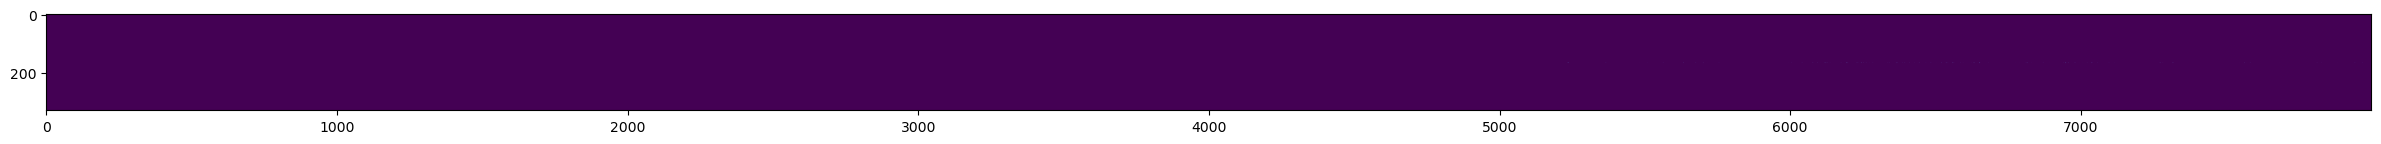

In [62]:
plt.imshow(new_atac_base)

[267457660.0, 32.60538, 267457660.0, 33.045177, 32.60538, 201.66351, 1114.8195, 30.81351, 32.8949, 36.154972]


/tmp/ipykernel_425156/629059034.py:23: UserWarning: Glyph 9 (	) missing from current font.
  fig.tight_layout()
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


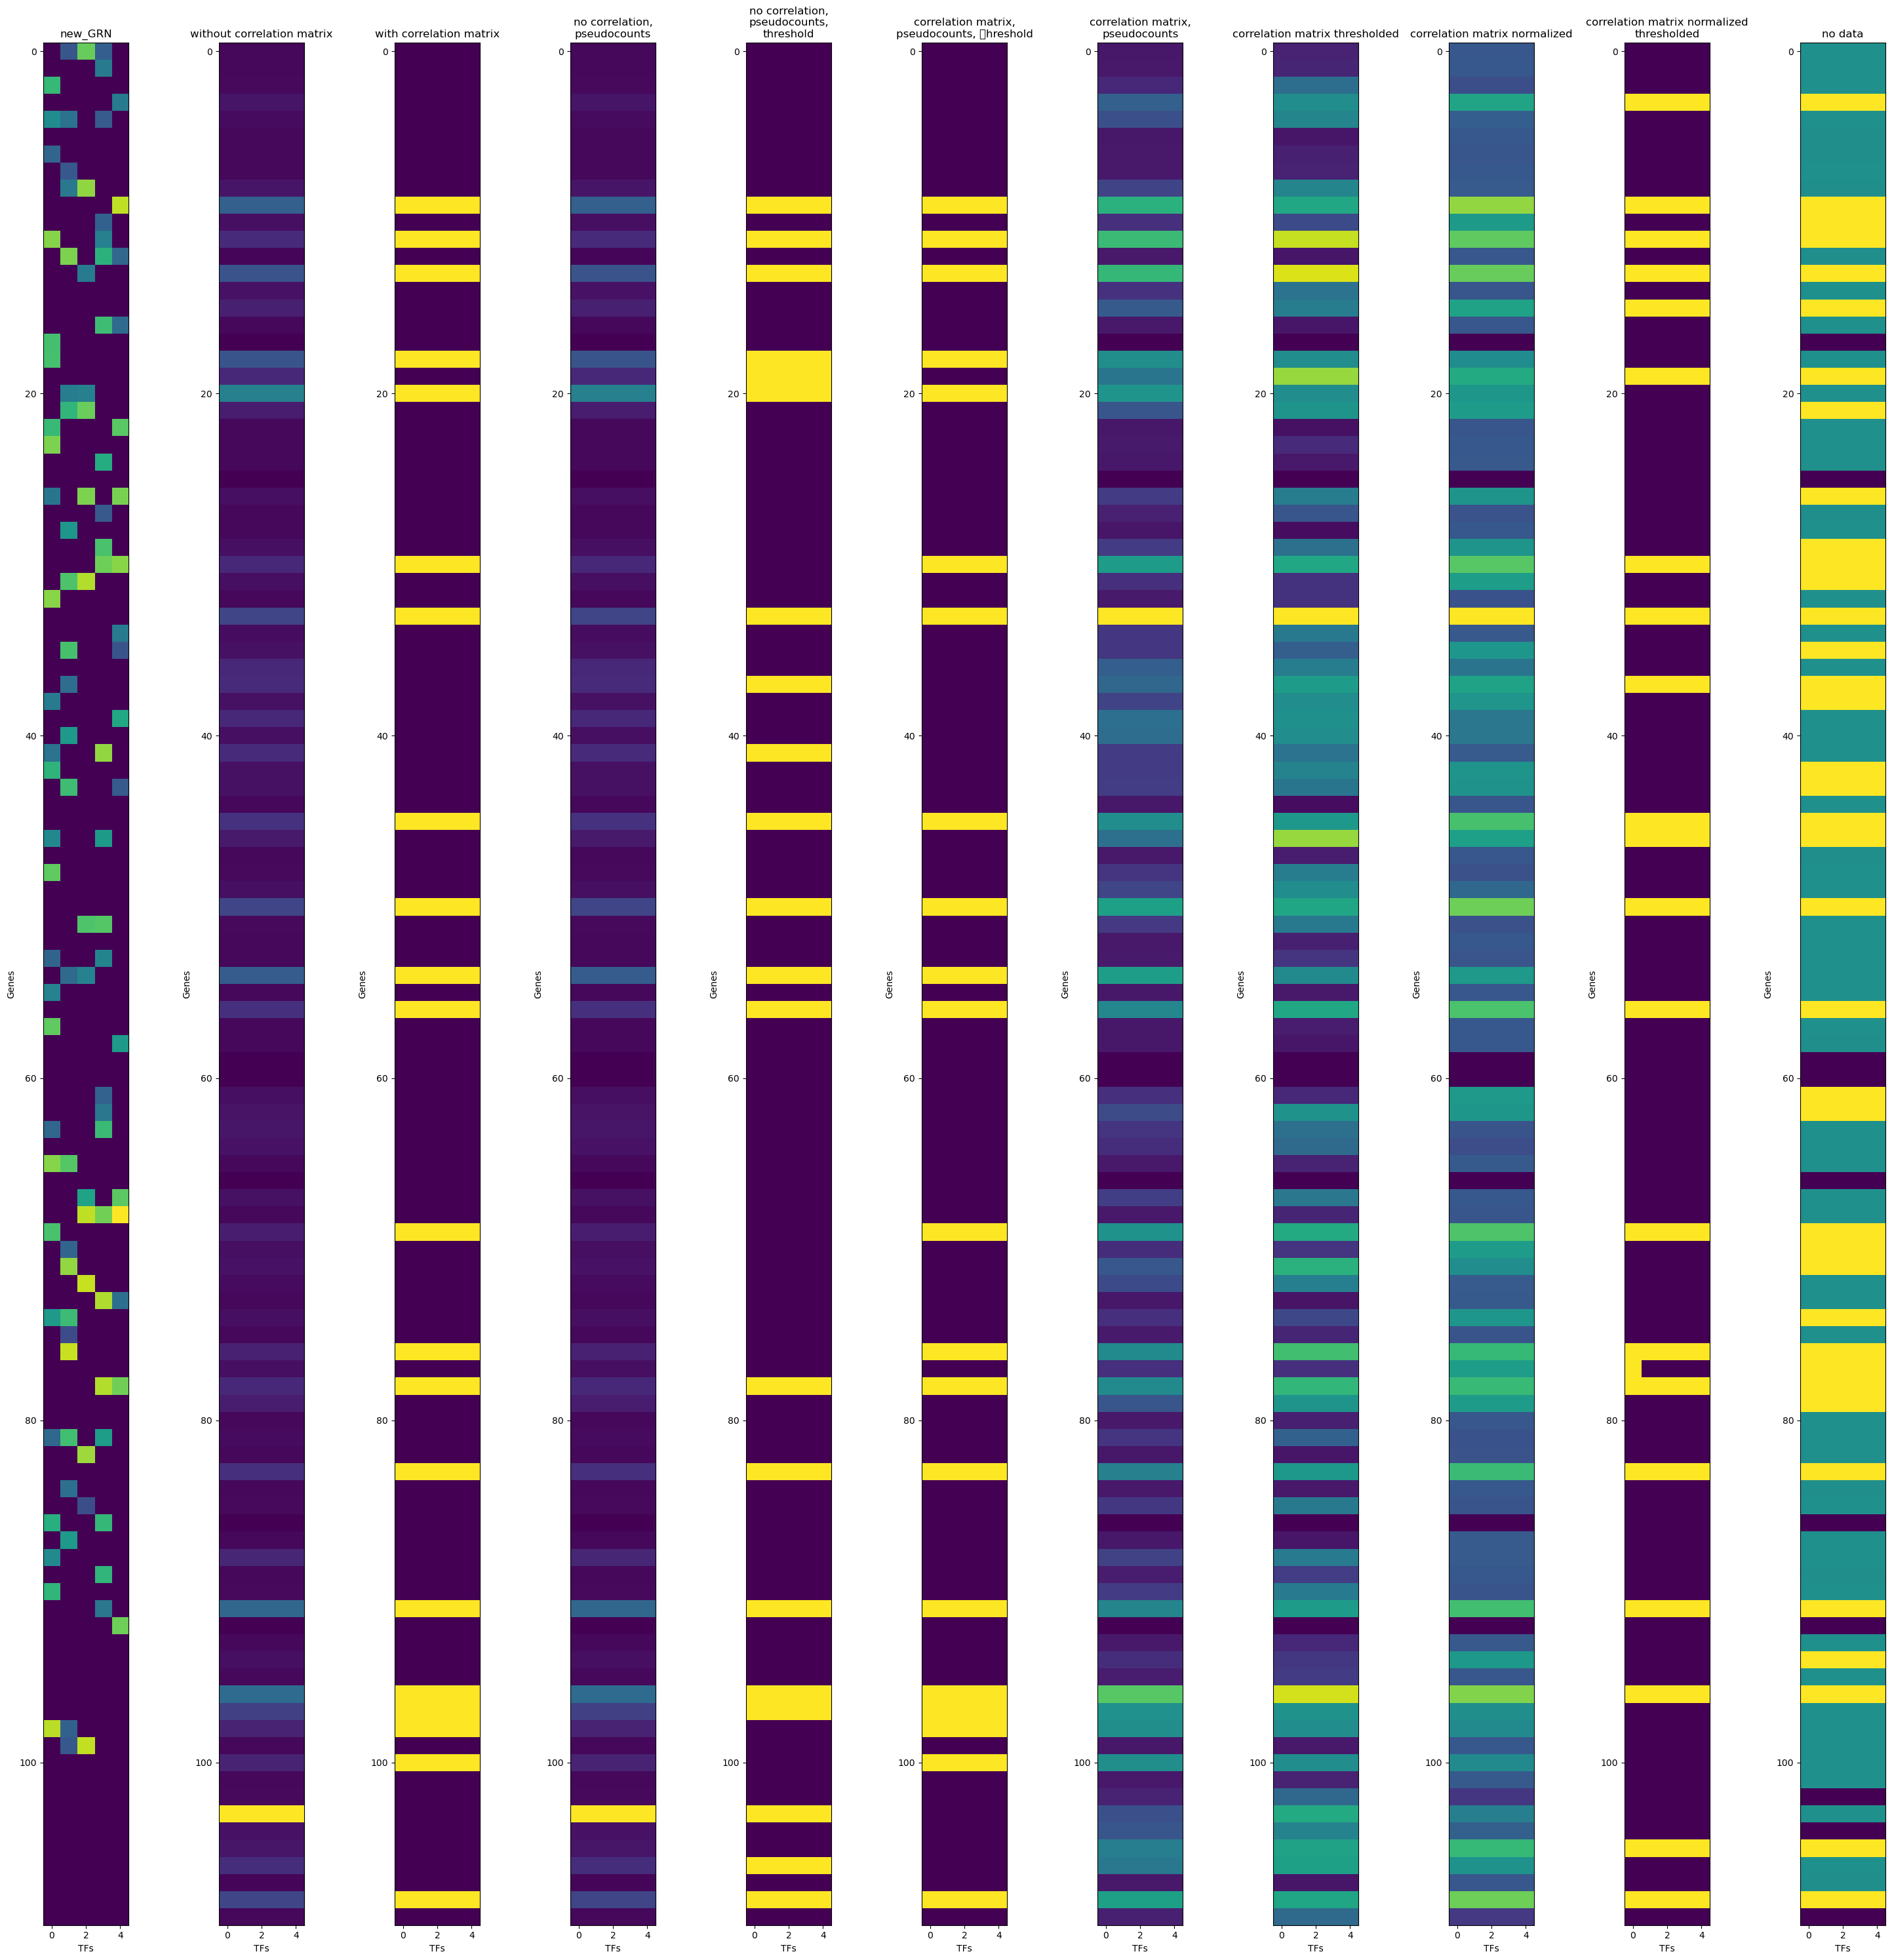

In [63]:
masks ={key:get_mask(**new_data,
                     **params,
                     ) for key, params in parameter_sets.items()}

#plt.imshow(np.corrcoef(atacseq_obs, dtype=float)* np.diag(np.ones(len(atacseq_obs), dtype=float)))
#plt.xticks(np.arange(0, 2, 0.1))
distances = [distance(new_grn, mask) for mask in masks.values()]
print(distances)
fig, ax = plt.subplots(nrows=1, ncols=len(masks)+1)
ax = ax.flatten()
ax[0].imshow(new_grn)

ax[0].set_title("new_GRN")
ax[0].set_xlabel("TFs")
ax[0].set_ylabel("Genes")
for n, (key, mask) in enumerate(masks.items()):
    ax[n+1].imshow(mask)
    ax[n+1].set_xlabel("TFs")
    ax[n+1].set_ylabel("Genes")
    ax[n+1].set_title(parameter_sets[key]["comment"])

#fig.suptitle("Different mask creation parameters")
fig.tight_layout()
#fig.subplots_adjust(top=0.88)
#fig.savefig(out_path/"figures"/"parameters_.pdf", format="pdf")

Text(0.5, 1.0, 'Distance of masks to the grn')

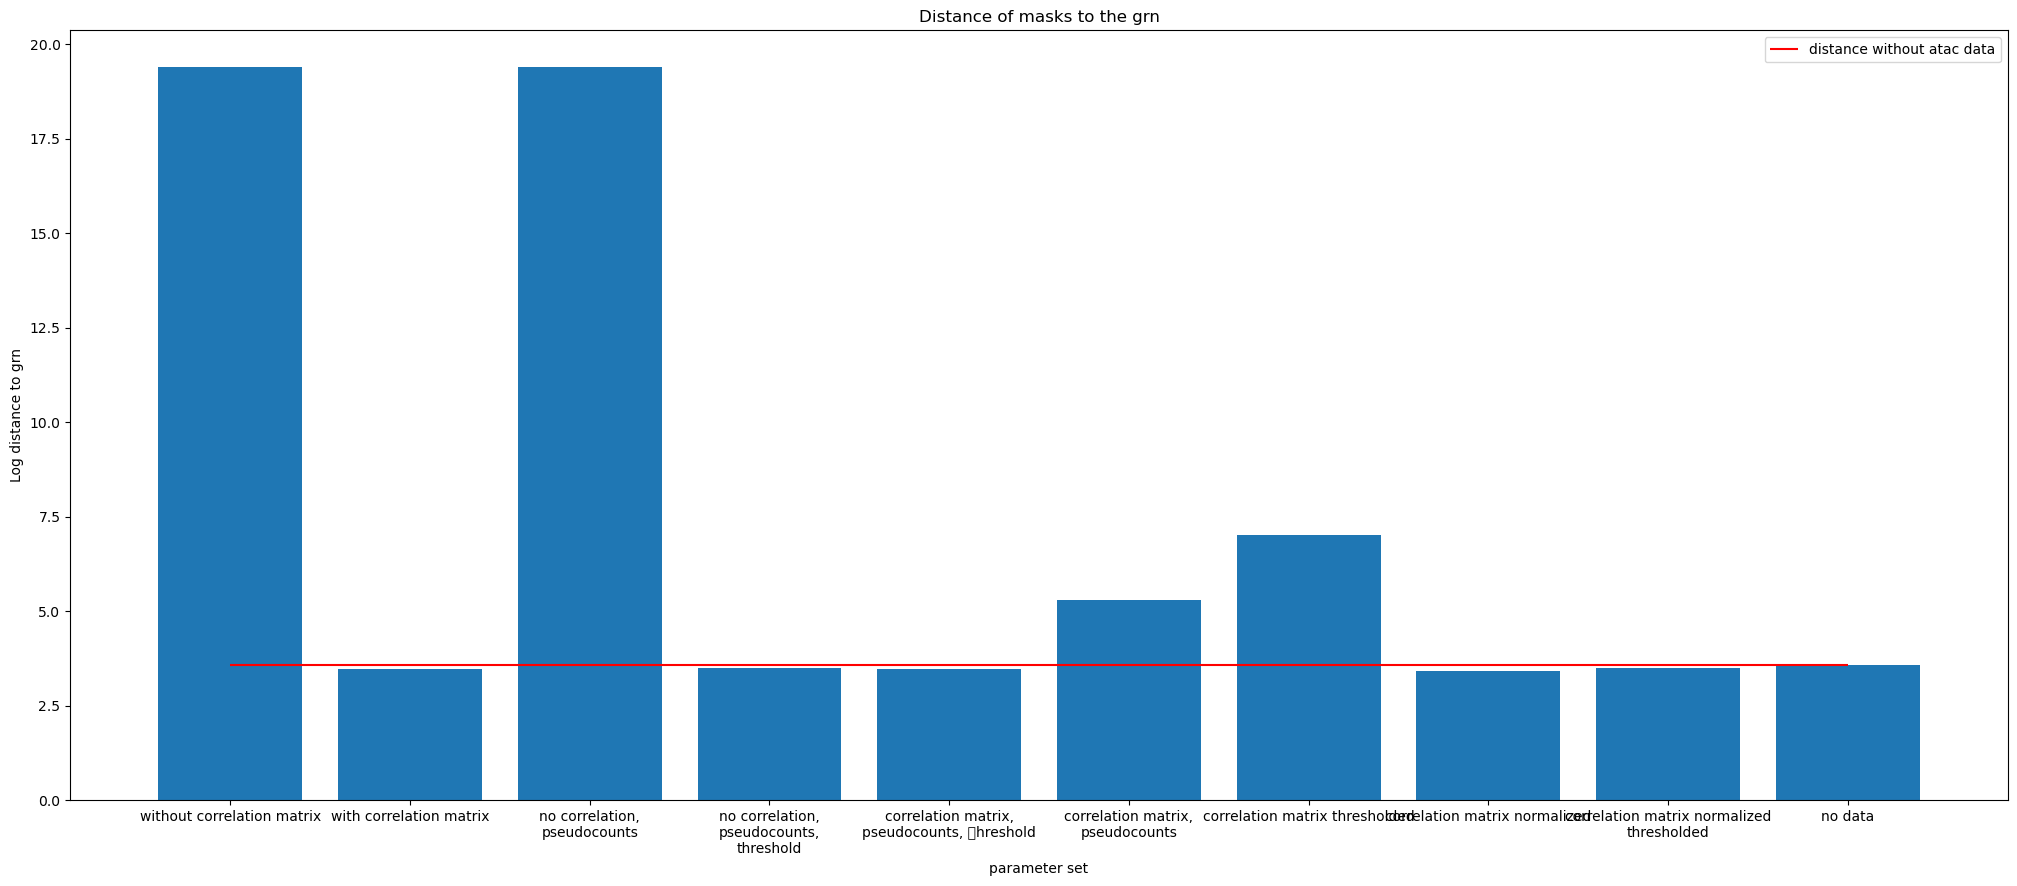

In [64]:
plt.rcParams["figure.figsize"] = (25,10)

plt.bar(comments, np.log(distances))
plt.ylabel("Log distance to grn")
plt.xlabel("parameter set")
plt.hlines(np.log(distances[-1]), xmin=-0, xmax=len(distances)-1, colors="red", label="distance without atac data")
plt.legend()
plt.title("Distance of masks to the grn")
#plt.savefig("./presentation/distances_bar_parameters.pdf")

In [65]:
# observe different noise parameters
plt.rcParams["figure.figsize"] = (30,30)

np.random.seed(SEED)
comments = [x["comment"] for x in parameter_sets.values()]
repeats =1
distances = np.empty((100, 8, repeats))
for p in np.arange(repeats):
    for n in np.arange(0, 10, 0.1):
        region_to_gene_noised = region_to_gene
        region_to_tf_noised = add_noise(region_to_tf, 0, n)
        masks ={key:get_mask(atac_base,
                             region_to_gene=region_to_gene_noised,
                             region_to_tf=region_to_tf_noised,
                             **params,
                             ) for key, params in parameter_sets.items()}
        distances[int(n*10), :, p] = [distance(grn, mask) for mask in masks.values()]

std = distances.std(axis=2)
distances = distances.mean(axis=2)

##fig, ax = plt.subplots(nrows=1, ncols=3)
##ax = ax.flatten()
#colors = [c for c in mc.XKCD_COLORS.keys()]
#for n, c in enumerate(distances.T):
#    plt.errorbar(np.arange(0, 1, 0.1), c,
#             yerr=std.T[n],
#             label=comments[n], color=colors[n])
#    plt.hlines(y=c.mean(), xmin=0, xmax=1, color=colors[n])
#plt.legend()
##fig.align_ylabels()
#plt.show()

ValueError: could not broadcast input array from shape (10,) into shape (8,)

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
width = 0.3
colors = [c for c in mc.XKCD_COLORS.keys()]
plt.bar(np.arange(0, 100), distances.T[3],
    #yerr=std.T[3],
    label=comments[3],
    width= width,
    #color=colors[3],
    )
#plt.hlines(y=c.mean(), xmin=0, xmax=1, color=colors[3])
plt.bar(np.arange(0, 100) +width, distances.T[-1],
    #yerr=std.T[-1],
    label=comments[-1],
    width= width,
    #color=colors[-1],
    )
#plt.hlines(y=c.mean(), xmin=0, xmax=1, color=colors[-1])
plt.xticks(np.arange(0, 100) + width / 2, )

plt.legend()
#fig.align_ylabels()
plt.title("Comparison of no data vs atac data when noise is present")
plt.ylabel("distance to the grn")
plt.xlabel("var of noise distribution")
#plt.savefig("./presentation/distance_noised_bar_params5.pdf")

In [ ]:
for key, params in parameter_sets.items():
    filename = key+".pickle"
    with open(out_path/"parameters"/filename, "wb") as handle:
        pickle.dump(params, file=handle)

In [ ]:
mtxs = [add_noise(grn, mean=0, std=n*0.1) for n in range(0, 20)]
fig, ax = plt.subplots(nrows=1, ncols=len(mtxs)+1)
ax = ax.flatten()
ax[0].imshow(grn)

ax[0].set_title("GRN")
ax[0].set_xlabel("TFs")
ax[0].set_ylabel("Genes")
for 3, mask in enumerate(mtxs):
    ax[3+1].imshow(mask)
    ax[3+1].set_xlabel("TFs")
    ax[3+1].set_ylabel("Genes")
    ax[3+1].set_title(3)

fig.tight_layout()